# Model training



In [1]:
from config import *
import torch

from OFDM_SDR_Functions_torch import *
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as tFunc # usually F, but that is reserved for other use
import csv
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# Display the selected device
print(device)

# Test tensor creation on the selected device
if device.type != "cpu":
    x = torch.ones(1, device=device)
    print(x)

#device = "cpu" # Force CPU for now, trouble with converting complex tensors to mps

cuda:0
tensor([1.], device='cuda:0')


## Dataloader
Load dataset created earlier and make the torch dataloaders. The dataset structure is defined in the config.py file.

In [2]:
dataset = CustomDataset()
dataset = torch.load('data/ofdm_dataset.pth')
saved_model_path = 'data/rx_model.pth'

batch_size = 16

# train, validation and test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)


## NN-receiver model
Create a torch model for the receiver. The structure follows loosely the DeepRX (https://arxiv.org/abs/2005.01494) structure, but is simplified and lighter. The model architecture is stored in `models_local.py`. 

In [3]:
from models_local import *

model = RXModel(Qm).to(device)

## Model training

Set the optimizer and loss function. 

In [4]:
import torch.optim as optim


initial_lr = 0.001 # Initial learning rate
final_lr = 0.0002 # Final learning rate at the end
num_epochs = 200 # epochs for learning rate scheduler decay

# Define the model's optimizer
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Lambda function for learning rate decay
lambda_lr = lambda epoch: final_lr / initial_lr + (1 - epoch / num_epochs) * (1 - final_lr / initial_lr)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)


criterion = nn.BCELoss()

Load earlier model for further training or start from scratch 

In [5]:
saved_model_path = 'data/rx_model_40.pth'
performance_csv_path = 'data/performance_details.csv'

# Check if a saved model exists
if os.path.exists(saved_model_path):
    # Load the existing model and epoch
    checkpoint = torch.load(saved_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Existing model loaded from {saved_model_path}, Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    print("No saved model found. Training from scratch.")



No saved model found. Training from scratch.


Model performance data

In [6]:
# Lists to store performance details for plotting
train_losses = []
val_losses = []
val_BERs = []

# Check if a performance CSV file exists
if not os.path.exists(performance_csv_path):
    # Create a new CSV file and write headers
    with open(performance_csv_path, mode='w', newline='') as csv_file:
        fieldnames = ['Epoch', 'Training Loss', 'Validation Loss', 'Validation BER']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()


In [7]:
TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=False).to(device) # TTI mask
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power).to(device) # pilot symbols

# remove DC and FFT offsets from TTI mask_RE and add third dimension size of Qm, and expand TTI mask values into the third dimension
TTI_mask_RE_small = TTI_mask_RE[:, FFT_offset:-FFT_offset]
middle_index = TTI_mask_RE_small.size(1) // 2
TTI_mask_RE_small = torch.cat((TTI_mask_RE_small[:, :middle_index], TTI_mask_RE_small[:, middle_index + 1:]), dim=1)

TTI_mask_RE_3d = TTI_mask_RE_small.unsqueeze(-1).expand(batch_size, S, F-1, Qm)

Training loop

In [8]:
# Training loop
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0

    for pdsch_iq, pilot_iq, labels in train_loader:
        pdsch_iq, pilot_iq, labels = pdsch_iq.to(device), pilot_iq.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model((pdsch_iq, pilot_iq))  # forward pass
        loss = criterion(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Update the learning rate
    scheduler.step()

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for val_pdsch_iq, val_pilot_iq, val_labels in val_loader:
            val_pdsch_iq, val_pilot_iq, val_labels = val_pdsch_iq.to(device), val_pilot_iq.to(device), val_labels.to(device)
            val_outputs = model((val_pdsch_iq, val_pilot_iq))
            val_loss = criterion(val_outputs, val_labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != val_labels).float()  # Count of unequal bits
            error_rate = error_count / len(val_labels.flatten())  # Error rate calculation
            BER = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places

    model.train()  # Set the model back to training mode

    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    val_BERs.append(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER:.4f}, learning rate: {scheduler.get_last_lr()[0]:.4f}")

    # Save performance details in the CSV file
    with open(performance_csv_path, mode='a', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow([epoch + 1, average_loss, val_loss.item(), BER.item()])

    if (epoch + 1) % 5 == 0:
        # Save model along with the current epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }
        torch.save(checkpoint, f'data/rx_model_{epoch + 1}.pth')
        print(f"Model saved at epoch {epoch + 1}")

# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
torch.save(checkpoint, 'data/rx_model.pth')


Epoch [1/200], Loss: 0.6920, Val Loss: 0.6758, Val BER: 0.4710, learning rate: 0.0010
Epoch [2/200], Loss: 0.6772, Val Loss: 0.6780, Val BER: 0.4990, learning rate: 0.0010
Epoch [3/200], Loss: 0.6588, Val Loss: 0.4223, Val BER: 0.2460, learning rate: 0.0010
Epoch [4/200], Loss: 0.1932, Val Loss: 0.0296, Val BER: 0.0110, learning rate: 0.0010
Epoch [5/200], Loss: 0.0197, Val Loss: 0.0177, Val BER: 0.0060, learning rate: 0.0010
Model saved at epoch 5
Epoch [6/200], Loss: 0.0126, Val Loss: 0.0095, Val BER: 0.0030, learning rate: 0.0010
Epoch [7/200], Loss: 0.0888, Val Loss: 0.0119, Val BER: 0.0040, learning rate: 0.0010
Epoch [8/200], Loss: 0.0106, Val Loss: 0.0062, Val BER: 0.0020, learning rate: 0.0010
Epoch [9/200], Loss: 0.0087, Val Loss: 0.0063, Val BER: 0.0020, learning rate: 0.0010
Epoch [10/200], Loss: 0.0076, Val Loss: 0.0082, Val BER: 0.0030, learning rate: 0.0010
Model saved at epoch 10
Epoch [11/200], Loss: 0.0070, Val Loss: 0.0119, Val BER: 0.0040, learning rate: 0.0010


KeyboardInterrupt: 

```
Epoch [1/200], Loss: 0.6900, Val Loss: 0.6770, Val BER: 0.4820
Epoch [2/200], Loss: 0.6769, Val Loss: 0.6690, Val BER: 0.4590
Epoch [3/200], Loss: 0.4725, Val Loss: 0.3565, Val BER: 0.2150
Epoch [4/200], Loss: 0.2784, Val Loss: 0.2097, Val BER: 0.1060
Epoch [5/200], Loss: 0.1978, Val Loss: 0.1299, Val BER: 0.0620
Model saved at epoch 5
Epoch [6/200], Loss: 0.1658, Val Loss: 0.1788, Val BER: 0.0850
Epoch [7/200], Loss: 0.0978, Val Loss: 0.0792, Val BER: 0.0370
Epoch [8/200], Loss: 0.1464, Val Loss: 0.1386, Val BER: 0.0660
Epoch [9/200], Loss: 0.1023, Val Loss: 0.0720, Val BER: 0.0330
Epoch [10/200], Loss: 0.1284, Val Loss: 0.1032, Val BER: 0.0490
Model saved at epoch 10
Epoch [11/200], Loss: 0.0843, Val Loss: 0.0798, Val BER: 0.0360
Epoch [12/200], Loss: 0.1543, Val Loss: 0.1698, Val BER: 0.0820
Epoch [13/200], Loss: 0.0941, Val Loss: 0.0725, Val BER: 0.0320
Epoch [14/200], Loss: 0.1259, Val Loss: 0.0796, Val BER: 0.0350
Epoch [15/200], Loss: 0.0686, Val Loss: 0.0867, Val BER: 0.0370
...

## Model performance during training
Visualize the performance during training

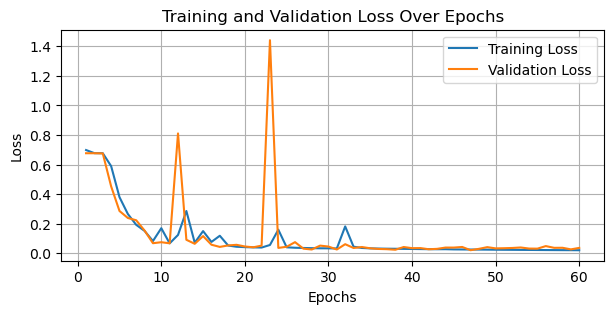

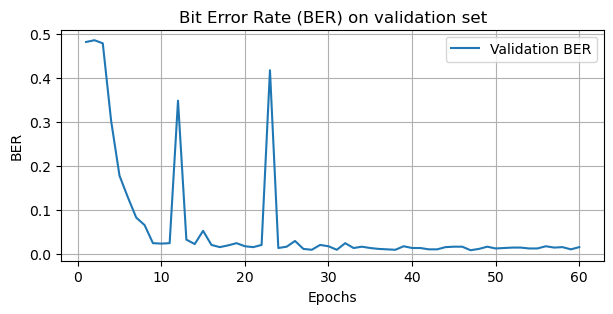

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV data
csv_path = 'data/performance_details.csv'
df = pd.read_csv(csv_path)

# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(df['Epoch'], df['Training Loss'], label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.savefig('pics/training_loss.png')
plt.show()

# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(df['Epoch'], df['Validation BER'], label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)
plt.savefig('pics/training_ber.png')
plt.show()

Please note that the training and validation data exhibit deep frequency-selective dips and additional noise, preventing the validation Bit Error Rate (BER) from reaching 0. Nevertheless, the model demonstrates effective learning in decoding the complex IQ signals and assosiating the symbols with the bits.